## Fetch the runs and collate information in a dataframe

In [1]:
import wandb

api = wandb.Api()
entity, project = "sayakpaul", "keras-xla-benchmarks"  
runs = api.runs(entity + "/" + project) 
print(f"Total runs: {len(runs)}")

Total runs: 414


In [2]:
import pandas as pd

resolutions = []
accelerators = []

model_families = []
model_variants = []
xla_status = []

flops = []
params = []
throughputs = []

for run in runs:
    run_config = run.config
    run_summary = run.summary._json_dict

    model_families.append(run_config["family"])
    model_variants.append(run_config["variant"])
    resolutions.append(run_config["resolution"])
    xla_status.append(run_config["xla"])

    accelerator_name = run.name.split("@")[-1].split("-")[1]
    accelerators.append(accelerator_name)

    flops.append(run_summary["FLOPs (giga)"])
    params.append(run_summary["Num parameters (million)"])
    throughputs.append(run_summary["Throughput (samples/sec)"])

viz_df = pd.DataFrame(
    {
        "model_family": model_families,
        "model_variant": model_variants,
        "resolution": resolutions,
        "xla": xla_status,
        "accelerator": accelerators,
        "flop (giga)": flops,
        "params (million)": params,
        "throughput (samples/sec)": throughputs,
    }
)
viz_df.head()

,model_family,model_variant,resolution,xla,accelerator,flop (giga),params (million),throughput (samples/sec)
0,NASNet,nasnet_mobile,224,True,t4,0.57,5.33,375.47
1,NASNet,nasnet_mobile,224,False,t4,0.57,5.33,11.82
2,NASNet,nasnet_large,331,True,t4,23.84,88.95,42.37
3,NASNet,nasnet_large,331,False,t4,23.84,88.95,8.79
4,DenseNet,densenet_201,224,True,t4,4.29,20.24,184.93


In [3]:
viz_df["accelerator"].unique()

array(['t4', 'v100', 'a100'], dtype=object)

## Filter w.r.t accelerator

In [4]:
def plot_topk_per_accelerator(
    accelerator="a100", topk=10, resolution=224, xla_status=True
):
    filtered_df = viz_df[viz_df["accelerator"] == accelerator]
    subset_df = filtered_df.query(f"resolution == {resolution} and xla == {xla_status}")
    topk_df = subset_df.nlargest(topk, ["throughput (samples/sec)"])
    return topk_df

In [9]:
# Adapted from
# https://github.com/nlp-with-transformers/notebooks/blob/main/08_model-compression.ipynb

import matplotlib.pyplot as plt


def plot_metrics(df, savefig=False):
    for model_variant in df["model_variant"]:
        filtered = df.query(f"model_variant == '{model_variant}'")
        plt.scatter(
            filtered["flop (giga)"],
            filtered["throughput (samples/sec)"],
            alpha=0.5,
            s=filtered["params (million)"] * 5,
            label=model_variant,
            marker="o",
        )

    legend = plt.legend(bbox_to_anchor=(1, 1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylabel("Throughput (samples/sec)", fontsize=14)
    plt.xlabel("FLOPS (giga)", fontsize=14)

    accelerator_name = df["accelerator"].unique()[0]
    resolution = df["resolution"].unique()[0]
    xla_status = df["xla"].unique()[0]
    plt.title(
        f"Accelerator: {accelerator_name}, Resolution: {resolution}, XLA: {xla_status}",
        fontsize=14,
    )
    if not savefig:
        plt.show()
    else:
        plot_name = f"{accelerator_name}_{resolution}_{xla_status}.png"
        plt.savefig(plot_name, dpi=300, bbox_inches="tight")

### A100

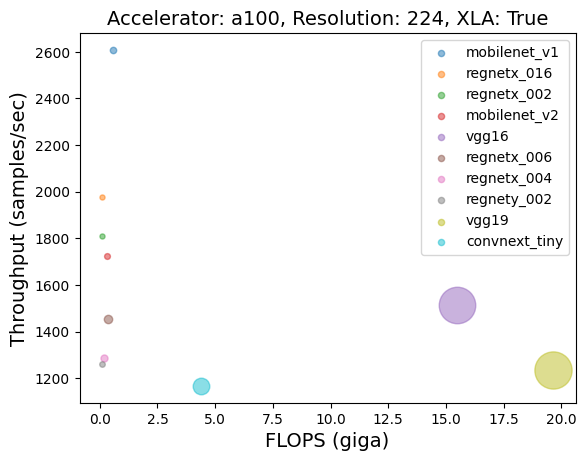

In [10]:
a100_df = plot_topk_per_accelerator("a100")
plot_metrics(a100_df)

### V100

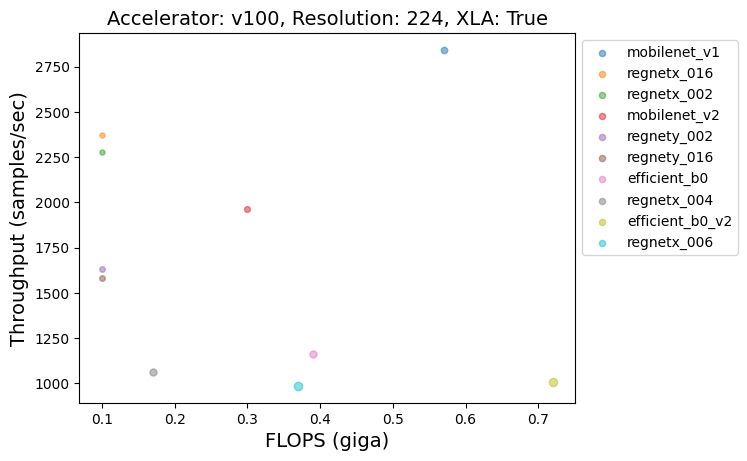

In [11]:
v100_df = plot_topk_per_accelerator("v100")
plot_metrics(v100_df)

### T4

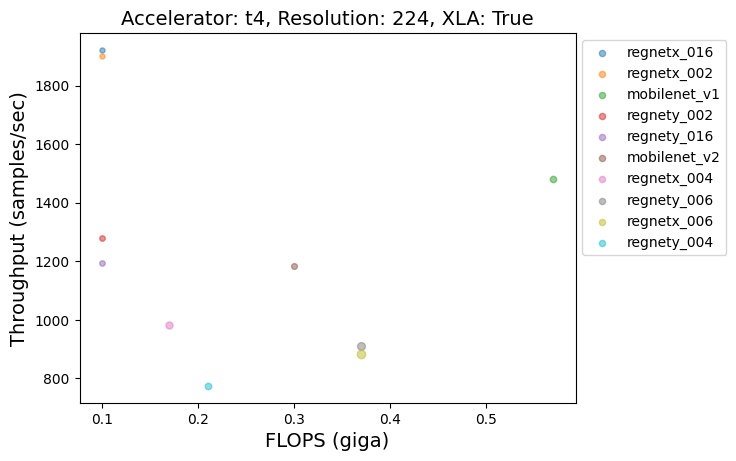

In [12]:
t4_df = plot_topk_per_accelerator("t4")
plot_metrics(t4_df)

For each accelerator type, the trend of the models leading to the highest amount of throughput seem to vary a little bit. 

## Resolution-wise throughput distribution

In [13]:
viz_df.resolution.unique()

array([224, 331, 299, 384, 480, 300, 260, 240, 600, 528, 456, 380])

In [17]:
# Grouping the dataframe by unique resolutions and finding the 
# model variant with highest throughput per group.
grouped = viz_df.groupby("resolution")["throughput (samples/sec)"].idxmax()

# Selecting the rows with the highest throughput per group.
result = viz_df.loc[grouped, viz_df.columns]
result

,model_family,model_variant,resolution,xla,accelerator,flop (giga),params (million),throughput (samples/sec)
136,MobileNet_V1,mobilenet_v1,224,True,v100,0.57,4.25,2842.09
162,EfficientNet_V2,efficient_b1_v2,240,True,v100,1.21,8.21,866.32
159,EfficientNet_V2,efficient_b2_v2,260,True,v100,1.71,10.18,738.15
342,Xception,xception,299,True,a100,8.36,22.91,793.82
366,EfficientNet_V1,efficient_b3,300,True,a100,1.86,12.32,578.09
278,NASNet,nasnet_large,331,True,a100,23.84,88.95,149.77
364,EfficientNet_V1,efficient_b4,380,True,a100,4.46,19.47,463.45
344,EfficientNet_V2,efficient_s_v2,384,True,a100,8.41,21.61,474.41
362,EfficientNet_V1,efficient_b5,456,True,a100,10.40,30.56,268.44
346,EfficientNet_V2,efficient_m_v2,480,True,a100,24.69,54.43,238.62


This means that for each resolution the highest throughput seems to have a relationship with the accelerator used for running the benchmark. 

## Highest amount of speedup from XLA grouped by model family

Thanks to ChatGPT for the code used in this section.

### Absolute speedup

In [20]:
# Filter rows where xla is True (XLA enabled).
xla_enabled = viz_df[viz_df["xla"]]

# Filter rows where xla is False (XLA disabled).
xla_disabled = viz_df[~viz_df["xla"]]

# Group by 'model_family' and calculate the speedup for each model variant.
grouped = []
for model_family, group in xla_enabled.groupby("model_family"):
    for model_variant, variant_group in group.groupby("model_variant"):
        throughput_with_xla = variant_group["throughput (samples/sec)"].values[0]
        throughput_without_xla = xla_disabled[
            (xla_disabled["model_family"] == model_family)
            & (xla_disabled["model_variant"] == model_variant)
        ]["throughput (samples/sec)"].values[0]
        speedup = throughput_with_xla - throughput_without_xla
        grouped.append(
            {
                "model_family": model_family,
                "model_variant": model_variant,
                "speedup": speedup,
            }
        )

# Create a dataframe from the grouped results.
result = pd.DataFrame(grouped)

# Find the model variant with the highest speedup per model family.
max_speedup = result.groupby("model_family")["speedup"].idxmax()
result_max_speedup = result.loc[max_speedup]
result_max_speedup.sort_values(by="speedup", ascending=False)

,model_family,model_variant,speedup
33,RegNet_X,regnetx_016,1856.43
25,MobileNet_V1,mobilenet_v1,1377.84
41,RegNet_Y,regnety_002,1231.72
26,MobileNet_V2,mobilenet_v2,1124.36
8,EfficientNet_V1,efficient_b0,722.38
16,EfficientNet_V2,efficient_b0_v2,608.53
28,NASNet,nasnet_mobile,363.65
5,DenseNet,densenet_121,311.11
65,ResNet_V2,resnet50_v2,292.65
62,ResNet_V1,resnet50_v1,246.46


### In terms of relative percentages

In [21]:
# Filter rows where xla is True (XLA enabled).
xla_enabled = viz_df.query("xla == True")

# Filter rows where xla is False (XLA disabled).
xla_disabled = viz_df.query("xla == False")

# Group by 'model_family' and calculate the speedup for each model variant.
grouped = []
for model_family, group in xla_enabled.groupby("model_family"):
    for model_variant, variant_group in group.groupby("model_variant"):
        throughput_with_xla = variant_group["throughput (samples/sec)"].values[0]
        throughput_without_xla = xla_disabled.query(
            "model_family == @model_family and model_variant == @model_variant"
        )["throughput (samples/sec)"].values[0]
        speedup_percentage = (
            (throughput_with_xla - throughput_without_xla) / throughput_without_xla
        ) * 100
        grouped.append(
            {
                "model_family": model_family,
                "model_variant": model_variant,
                "speedup_percentage": speedup_percentage,
            }
        )

# Create a dataframe from the grouped results.
result = pd.DataFrame(grouped)

# Find the model variant with the highest speedup percentage per model family.
max_speedup = result.groupby("model_family")["speedup_percentage"].idxmax()
result_max_speedup = result.loc[max_speedup]
result_max_speedup.sort_values(by="speedup_percentage", ascending=False)

,model_family,model_variant,speedup_percentage
28,NASNet,nasnet_mobile,3076.565144
33,RegNet_X,regnetx_016,2841.184573
41,RegNet_Y,regnety_002,2599.113737
8,EfficientNet_V1,efficient_b0,2109.138686
16,EfficientNet_V2,efficient_b0_v2,2007.025066
26,MobileNet_V2,mobilenet_v2,1832.100375
25,MobileNet_V1,mobilenet_v1,1328.550767
6,DenseNet,densenet_169,1265.997770
55,ResNetRS,resnetrs_200,805.882353
23,Inception,inception_resnetv2,656.532067
